# 🧪 Annotation QA Toolkit

This notebook compares human vs. machine annotations and highlights mismatches for quality assurance in clinical NLP.

In [1]:
!pip install matplotlib seaborn


In [2]:
import pandas as pd

# Set display options for better visibility
pd.set_option('display.max_colwidth', None)


## 🔍 Load Annotations

In [3]:
# Update these paths if necessary
human_path = "human_annotations.csv"
machine_path = "machine_annotations.csv"

# Load the CSV files
df_human = pd.read_csv(human_path)
df_machine = pd.read_csv(machine_path)

# Preview human annotations
print("🧑 Human Annotations:")
display(df_human)

# Preview machine annotations
print("\n🤖 Machine Annotations:")
display(df_machine)


🧑 Human Annotations:


,Text,Entity,Label,Start,End
0,The patient has diabetes.,diabetes,CONDITION,18,26
1,He was prescribed ibuprofen.,ibuprofen,MED,23,32
2,Patient denies chest pain.,chest pain,SYMPTOM,15,26
3,She takes metformin daily.,metformin,MED,10,19



🤖 Machine Annotations:


,Text,Entity,Label,Start,End
0,The patient has diabetes.,diabetes,DISEASE,18,26
1,He was prescribed ibuprofen.,ibuprofen,MED,23,32
2,Patient denies chest pain.,chest,SYMPTOM,15,20
3,She takes metformin daily.,metformin,MEDICATION,10,19


## 🔍 Step 2: Compare Human vs Machine Annotations

In [4]:

# Merge based on Text and character span
merged = pd.merge(
    df_human,
    df_machine,
    on=["Text", "Start", "End"],
    how="outer",
    suffixes=("_Human", "_Machine"),
    indicator=True
)

# Initialize the Match_Type column
def classify_match(row):
    if row["_merge"] == "left_only":
        return "❌ Machine Missing"
    elif row["_merge"] == "right_only":
        return "❌ Human Missing"
    else:
        if row["Entity_Human"] != row["Entity_Machine"]:
            return "❌ Span Mismatch"
        elif row["Label_Human"] != row["Label_Machine"]:
            return "❌ Label Mismatch"
        else:
            return "✅ Exact Match"

merged["Match_Type"] = merged.apply(classify_match, axis=1)

# Display the results
display(merged[[
    "Text", 
    "Entity_Human", "Label_Human", 
    "Entity_Machine", "Label_Machine", 
    "Match_Type"
]])


,Text,Entity_Human,Label_Human,Entity_Machine,Label_Machine,Match_Type
0,He was prescribed ibuprofen.,ibuprofen,MED,ibuprofen,MED,✅ Exact Match
1,Patient denies chest pain.,NaN,NaN,chest,SYMPTOM,❌ Human Missing
2,Patient denies chest pain.,chest pain,SYMPTOM,NaN,NaN,❌ Machine Missing
3,She takes metformin daily.,metformin,MED,metformin,MEDICATION,❌ Label Mismatch
4,The patient has diabetes.,diabetes,CONDITION,diabetes,DISEASE,❌ Label Mismatch


## 📊 Step 3: Evaluate Annotation Quality (Precision, Recall, F1)

In [5]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Filter out rows where either side is missing
eval_df = merged[merged['_merge'] == 'both'].copy()

# Create ground truth and prediction labels
y_true = eval_df["Label_Human"]
y_pred = eval_df["Label_Machine"]

# Convert to categorical evaluation (match = 1, mismatch = 0)
exact_match = y_true == y_pred
binary_true = [1] * len(y_true)
binary_pred = exact_match.astype(int)

# Calculate metrics
precision = precision_score(binary_true, binary_pred)
recall = recall_score(binary_true, binary_pred)
f1 = f1_score(binary_true, binary_pred)

print("📊 Evaluation Results:")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


📊 Evaluation Results:
Precision: 1.00
Recall:    0.33
F1 Score:  0.50


## 💾 Step 4: Export QA Results to CSV

In [6]:

# Export merged comparison results to CSV
merged.to_csv("annotation_comparison_results.csv", index=False)
print("✅ Exported to annotation_comparison_results.csv")


✅ Exported to annotation_comparison_results.csv


## 📊 Step 5: Visualize Match Types

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6196\240591494.py:13: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6196\240591494.py:13: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6196\240591494.py:13: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\clinical-nlp-projects\clinical-nlp-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\clinical-nlp-projects\clinical-nlp-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.pri

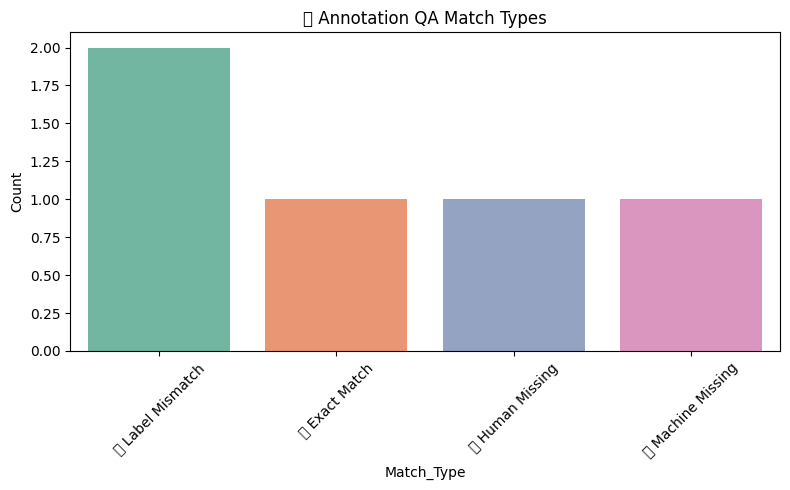

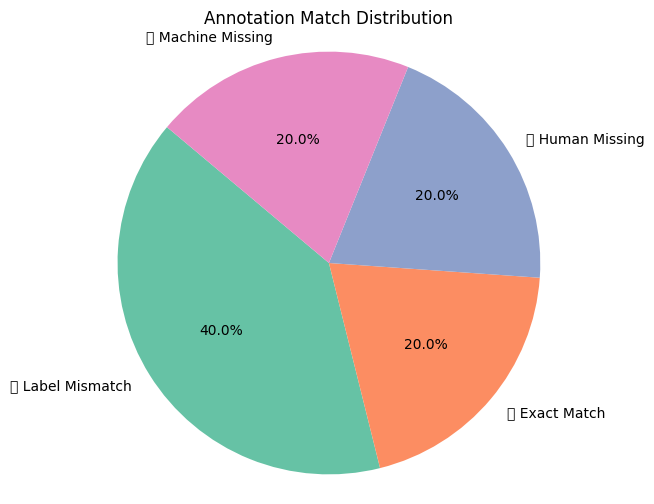

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns

# Count match types
match_counts = merged['Match_Type'].value_counts()

# Bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=match_counts.index, y=match_counts.values, hue=match_counts.index, palette="Set2", legend=False)
plt.title("🔍 Annotation QA Match Types")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Pie chart
plt.figure(figsize=(6, 6))
plt.pie(match_counts.values, labels=match_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Annotation Match Distribution")
plt.axis('equal')
plt.show()
